# Data Reduction and Transformation

In [118]:
import transformation_utils as utils
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import BinaryEncoder
from functools import reduce

In [ ]:
df = pd.read_csv("../data/integrated.csv")
target = 'playoff'

## Eliminating Redundant Features 

In [ ]:
df.drop(["round", "series", "tmIDWinner", "tmIDLoser", "W_series", "L_series", 'franchID', 'name'], axis=1, inplace=True)

## Feature Engineering

In [121]:
new_df = pd.DataFrame()
for year in df['year'].unique():
    for team in df['tmID'].unique():
        small_df = df[(df['tmID'] == team) & (df['year'] == year)]
        if small_df.empty:
            continue

        d = pd.DataFrame([small_df.iloc[0]])
        d.fillna(0, inplace=True)
        d['award_player'] = (small_df['award_player'].count())
        d['award_coach'] = d['award_coach'].apply(lambda i: 1 if i != 0 else 0)
        d['CBE_Sum'] = (small_df['CBE_Sum'].mean())
        d['height'] = (small_df['height'].mean())
        d['weight'] = (small_df['weight'].mean())
        d['playersAge'] = (2000 + df['year']) - utils.get_overall_age(small_df['birthDate'])
        d.drop('playerID', axis=1, inplace=True)
        d.drop('birthDate', axis=1, inplace=True)

        new_df = pd.concat([new_df, d])

df = new_df.sort_values(by=['year', 'tmID'])

In [122]:
mapping = {'L': 1,
           'W': 1,
           'N': 0}

df['semis'] = df['semis'].map(mapping)
df['finals'] = df['finals'].map(mapping)
df['firstRound'] = df['firstRound'].map(mapping)

## Manual Feature Selection

In [123]:
utils.print_columns(df)
df.drop(['attend', 'arena'], axis=1, inplace=True)

[ year, tmID, W_team_post, L_team_post, confID, rank, playoff, firstRound, semis, finals, o_fgm, o_fga, o_ftm, o_fta, o_3pm, o_3pa, o_oreb, o_dreb, o_reb, o_asts, o_pf, o_stl, o_to, o_blk, o_pts, d_fgm, d_fga, d_ftm, d_fta, d_3pm, d_3pa, d_oreb, d_dreb, d_reb, d_asts, d_pf, d_stl, d_to, d_blk, d_pts, won_team, lost_team, GP, homeW, homeL, awayW, awayL, confW, confL, min, attend, arena, coachID, stint, won_coach, lost_coach, post_wins, post_losses, CBE_Sum, height, weight, award_player, award_coach, playersAge ]


## Feature Encoding

In [124]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])
df['confID'] = le.fit_transform(df['confID'])

nominal_cols = ['tmID', 'coachID']
encoder = BinaryEncoder(cols = nominal_cols)
df = encoder.fit_transform(df)

key_cols = ['confID', 'year', 'firstRound', 'semis', 'finals', 'playoff']
nominal_cols = [col for col in df.columns if any (map(lambda x: x in col, nominal_cols))]
excluded_cols = nominal_cols + key_cols

numerical_cols = list(set(df.columns) - set(excluded_cols))

## Feature Scaling

In [125]:
scaler = RobustScaler()
normalizer = MinMaxScaler()

df[numerical_cols] = scaler.fit_transform(df.drop(excluded_cols, axis=1))
df[numerical_cols] = normalizer.fit_transform(df.drop(excluded_cols, axis=1))
df.head()

,year,tmID_0,tmID_1,tmID_2,tmID_3,tmID_4,W_team_post,L_team_post,confID,rank,...,won_coach,lost_coach,post_wins,post_losses,CBE_Sum,height,weight,award_player,award_coach,playersAge
85,2,0,0,0,0,1,0.766667,0.330043,0,0.381944,...,0.524980,0.245763,0.312217,0.256614,0.125000,0.138996,0.302577,0.300000,0.000000,0.166667
169,2,0,0,0,1,0,0.500000,0.625732,0,0.375000,...,0.273546,0.656780,0.357466,0.076720,0.166667,0.625483,0.301746,0.423810,0.000000,0.541667
337,2,0,0,0,1,1,0.000000,0.337606,0,0.511574,...,0.522523,0.567797,0.063348,0.193122,0.041667,0.590734,0.423109,0.471429,0.000000,0.416667
165,2,0,0,1,0,0,0.166667,0.476134,1,0.564815,...,0.227682,0.466102,0.497738,0.119048,0.125000,0.347490,0.542810,0.147619,0.333333,0.958333
228,2,0,0,1,0,1,0.000000,0.436789,0,0.344907,...,0.411138,0.313559,0.592760,0.174603,0.041667,0.332046,0.325021,0.204762,0.000000,0.208333


## Feature Selection

In [126]:
initial = df.columns
df = utils.select_features(df, target, excluded_cols)

print("Removed: ", set(initial) - set(df.columns))

Removed:  {'o_stl', 'd_ftm', 'd_blk', 'won_coach', 'o_fta', 'confL', 'lost_coach', 'd_dreb', 'o_to', 'confW', 'height', 'L_team_post', 'post_losses', 'd_to', 'd_oreb', 'post_wins', 'o_blk', 'd_pts', 'd_asts', 'homeL', 'homeW'}


In [127]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


## Feature Aggregation

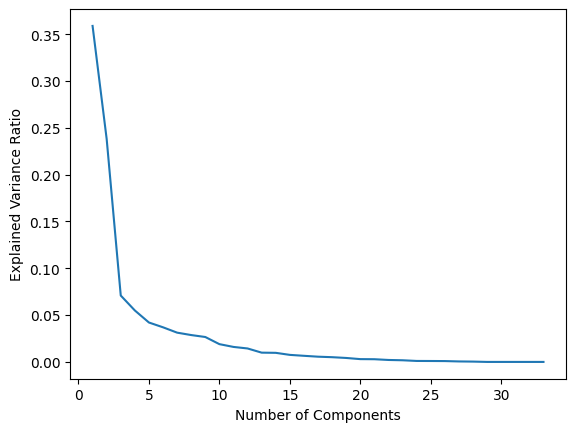

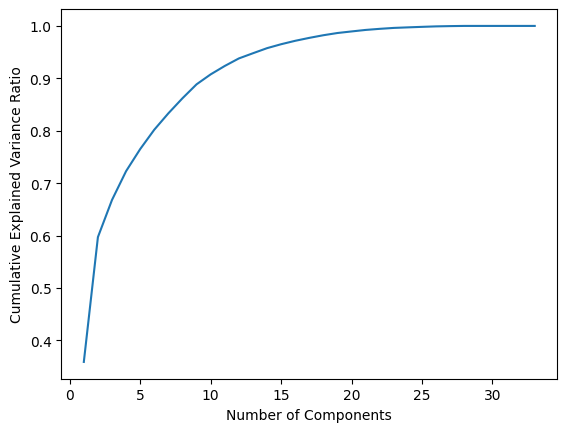

In [128]:
utils.plot_pca(df.drop(excluded_cols, axis=1))

In [129]:
n_components = 8
df = utils.feature_aggregation_pca(df, n_components, excluded_cols)
utils.print_columns(df)

[ PC1, PC2, PC3, PC4, PC5, PC6, PC7, PC8, tmID_0, tmID_1, tmID_2, tmID_3, tmID_4, coachID_0, coachID_1, coachID_2, coachID_3, coachID_4, coachID_5, confID, year, firstRound, semis, finals, playoff ]


## Checking for Correlation

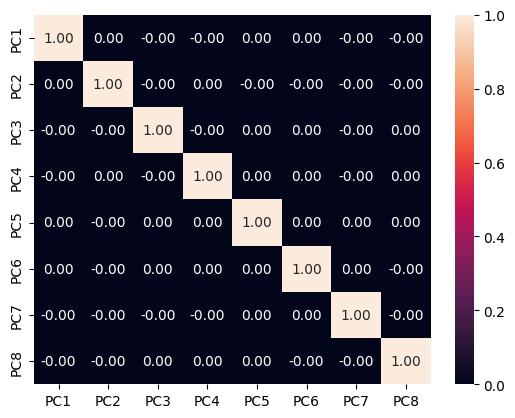

<Figure size 14400x14400 with 0 Axes>

In [130]:
utils.plot_correlation(df.drop(excluded_cols, axis=1))

## Checking for null values

In [131]:
print("Number of null values: ", df.isnull().sum().sum())

Number of null values:  0


# Saving the data

In [132]:
df.to_csv("../data/transformed.csv", index=False)